In [7]:
# Importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import torch

In [8]:
# Probar si funciona aceleración por GPU

print(tf.config.list_physical_devices('GPU'))
torch.cuda.is_available()


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [9]:
# Cargar datos
df = pd.read_csv("ipsaCompleto.csv")  # Debe tener "Date" y "Price"
df["Fecha"] = pd.to_datetime(df["Fecha"])
df = df.sort_values("Fecha")  # Asegurar orden temporal

In [10]:
# Normalizar precios entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
df["Valor IPSA"] = scaler.fit_transform(df["Valor IPSA"].values.reshape(-1, 1))

# Crear datos de entrenamiento con ventanas de tiempo
def crear_secuencias(datos, ventana=30):
    X, y = [], []
    for i in range(len(datos) - ventana):
        X.append(datos[i:i+ventana])
        y.append(datos[i+ventana])
    return np.array(X), np.array(y)

ventana = 30  # Usar los últimos 30 días para predecir
X, y = crear_secuencias(df["Valor IPSA"].values, ventana)

# Dividir datos en entrenamiento y prueba
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Reshape para LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
# Definir modelo LSTM
modelo = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilar modelo
modelo.compile(optimizer="adam", loss="mean_squared_error")

# Entrenar modelo
modelo.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_test, y_test))

I0000 00:00:1742604472.044014    4167 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/nekonix/.conda/envs/tomate/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


I0000 00:00:1742604474.055502    4801 cuda_dnn.cc:529] Loaded cuDNN version 90300


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.1596e-04 - val_loss: 4.2409e-04
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.5909e-04 - val_loss: 5.3766e-04
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.3745e-04 - val_loss: 3.6534e-04
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.2939e-04 - val_loss: 3.5555e-04
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.3571e-04 - val_loss: 3.2001e-04
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.4537e-04 - val_loss: 4.0267e-04
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.3977e-04 - val_loss: 2.9447e-04
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.2325e-04 - val_loss: 2.8835e-04
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.4029e-04 - val_loss: 4.0835e-04
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.5174e-04 - val_

In [12]:
# Hacer predicción para mañana
ultimos_datos = df["Valor IPSA"].values[-ventana:].reshape(1, ventana, 1)
prediccion = modelo.predict(ultimos_datos)
prediccion_real = scaler.inverse_transform(prediccion.reshape(-1, 1))

print(f"Predicción del IPSA para mañana: {prediccion_real[0][0]:.2f}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicción del IPSA para mañana: 7578.23


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


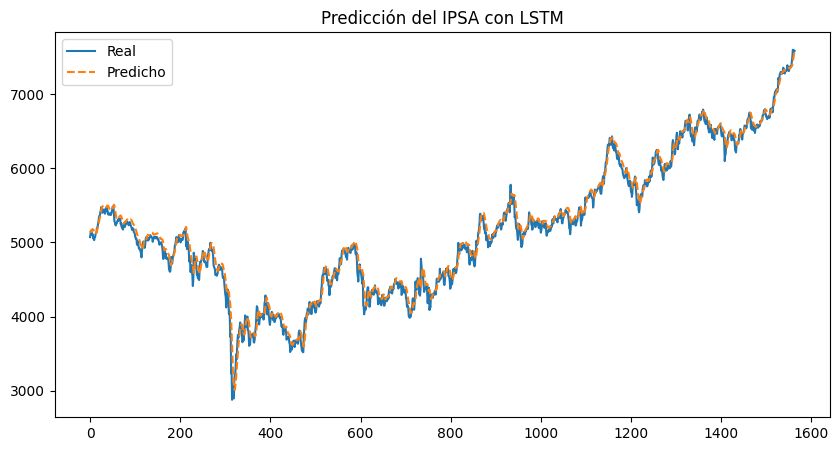

In [13]:
# Graficar predicciones vs. reales
predicciones = modelo.predict(X_test)
predicciones_real = scaler.inverse_transform(predicciones.reshape(-1, 1))
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label="Real")
plt.plot(predicciones_real, label="Predicho", linestyle="dashed")
plt.legend()
plt.title("Predicción del IPSA con LSTM")
plt.show()